# Importing essential libraries

In [1]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#Data Preparation and Exploration

In [2]:
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.1, random_state=101)

In [4]:
X_train.shape, y_train.shape

((45000, 32, 32, 3), (45000, 1))

In [5]:
X_valid.shape, y_valid.shape

((5000, 32, 32, 3), (5000, 1))

In [6]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [7]:
class_names = ['airplane', 'automobile', 'bird','cat','deer','dog','frog','horse','ship','truck']

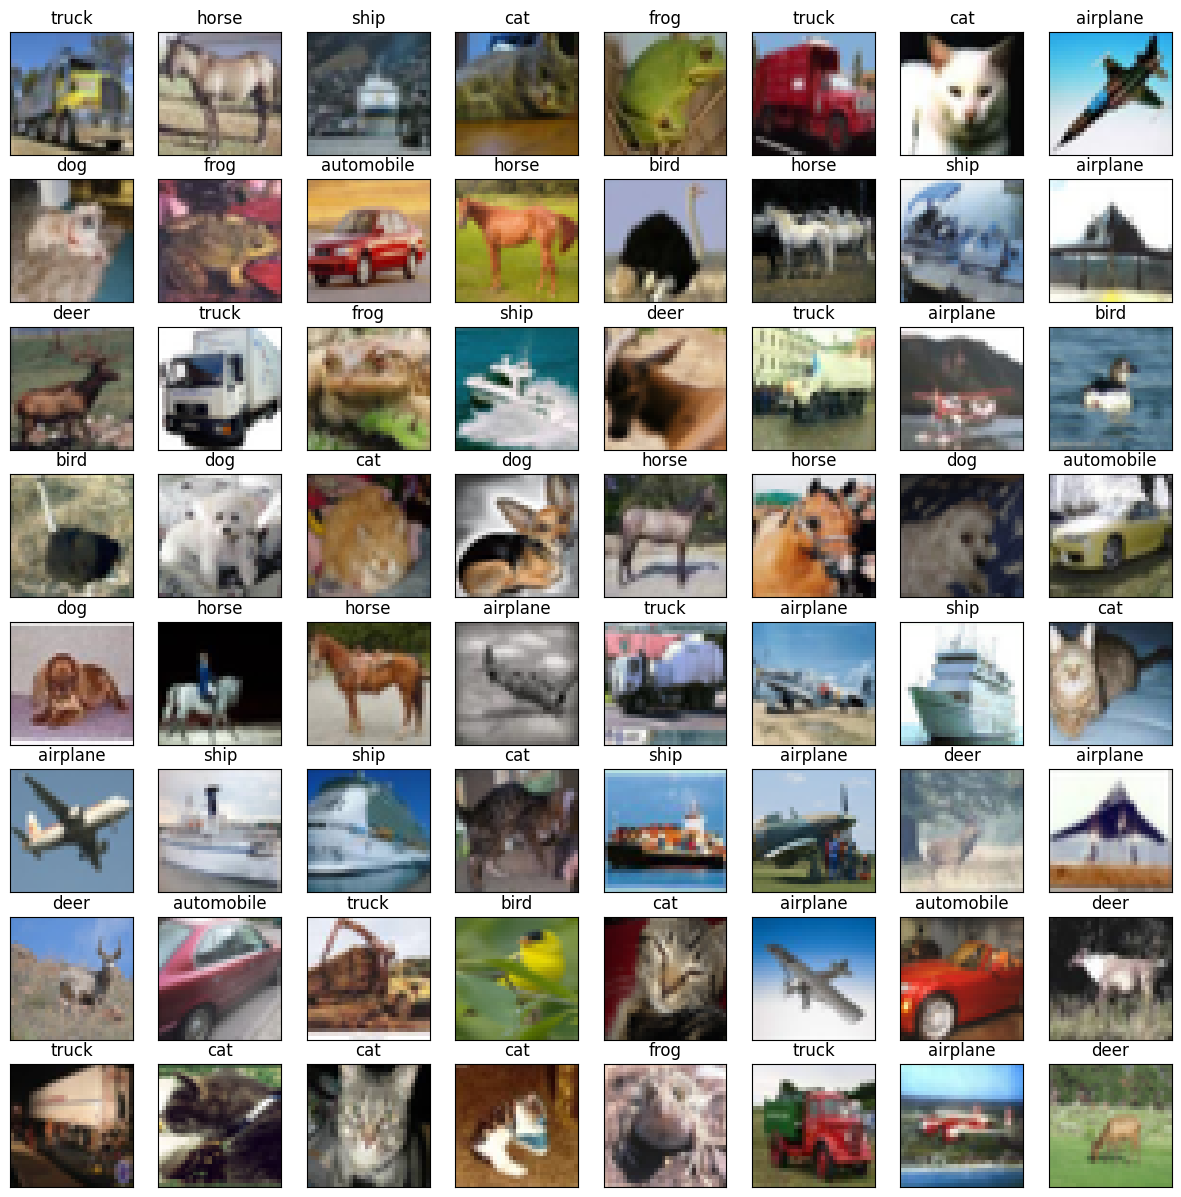

In [8]:
plt.figure(figsize=(15,15))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train[i])
  plt.title(class_names[y_train[i][0]])

plt.show()

#### Normalisation

In [9]:
#Converting pixel values to float32

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

#Calculate the mean and std of training images
mean = np.mean(X_train)
std = np.std(X_train)

#Normalize the data
X_train = (X_train-mean)/(std+.00000001)
X_test = (X_test-mean)/(std+.00000001)
X_valid = (X_valid-mean)/(std+.00000001)

#### One Hot Encoding of Labels

In [10]:
y_train = to_categorical(y_train,10)
y_valid = to_categorical(y_valid,10)
y_test = to_categorical(y_test,10)

## Level-1 Resnet50 Model

In [11]:
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
num_of_classes = 10

model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_of_classes, activation='softmax'))

In [14]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])

In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)

Epoch 1/10
1407/1407 - 549s - 390ms/step - acc: 0.4843 - loss: 1.5619 - val_acc: 0.8386 - val_loss: 0.6192 - learning_rate: 2.0000e-05
Epoch 2/10
1407/1407 - 470s - 334ms/step - acc: 0.7438 - loss: 0.8938 - val_acc: 0.9106 - val_loss: 0.4001 - learning_rate: 2.0000e-05
Epoch 3/10
1407/1407 - 469s - 333ms/step - acc: 0.8401 - loss: 0.6458 - val_acc: 0.9318 - val_loss: 0.2817 - learning_rate: 2.0000e-05
Epoch 4/10
1407/1407 - 470s - 334ms/step - acc: 0.8937 - loss: 0.4854 - val_acc: 0.9424 - val_loss: 0.2337 - learning_rate: 2.0000e-05
Epoch 5/10
1407/1407 - 469s - 334ms/step - acc: 0.9245 - loss: 0.3756 - val_acc: 0.9426 - val_loss: 0.2195 - learning_rate: 2.0000e-05
Epoch 6/10
1407/1407 - 469s - 333ms/step - acc: 0.9475 - loss: 0.2897 - val_acc: 0.9468 - val_loss: 0.1988 - learning_rate: 2.0000e-05
Epoch 7/10
1407/1407 - 470s - 334ms/step - acc: 0.9608 - loss: 0.2326 - val_acc: 0.9502 - val_loss: 0.1891 - learning_rate: 2.0000e-05
Epoch 8/10
1407/1407 - 469s - 333ms/step - acc: 0.9699 

# Level-1 Test Accuracy

In [17]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose = 1)

print(f'Test Accuracy : {test_acc}\nTestLoss: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - acc: 0.9455 - loss: 0.2143
Test Accuracy : 0.9460999965667725
TestLoss: 0.2094486504793167


# Level-2 Data Augmentation

In [18]:
data_generator = ImageDataGenerator(
    rotation_range = 15, #rotate images by up to 15 degree
    width_shift_range = .12, #shift images horizontally by upto 12% of width
    height_shift_range = 0.12,
    horizontal_flip =True,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    shear_range = 10, #Shear intesity (share angle in anti clockwise direction),
    channel_shift_range = 0.1
)

In [19]:
model.fit(data_generator.flow(X_train, y_train, batch_size=64),
                              epochs = 10,
                              validation_data = (X_valid, y_valid),
                              callbacks = [reduce_lr, early_stopping],
                              verbose=2)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 - 517s - 734ms/step - acc: 0.9106 - loss: 0.3655 - val_acc: 0.9546 - val_loss: 0.1767 - learning_rate: 2.0000e-05
Epoch 2/10
704/704 - 451s - 640ms/step - acc: 0.9255 - loss: 0.3119 - val_acc: 0.9570 - val_loss: 0.1571 - learning_rate: 2.0000e-05
Epoch 3/10
704/704 - 451s - 641ms/step - acc: 0.9349 - loss: 0.2751 - val_acc: 0.9516 - val_loss: 0.1747 - learning_rate: 2.0000e-05
Epoch 4/10
704/704 - 452s - 642ms/step - acc: 0.9421 - loss: 0.2547 - val_acc: 0.9610 - val_loss: 0.1561 - learning_rate: 2.0000e-05
Epoch 5/10
704/704 - 452s - 641ms/step - acc: 0.9473 - loss: 0.2357 - val_acc: 0.9600 - val_loss: 0.1400 - learning_rate: 2.0000e-05
Epoch 6/10
704/704 - 451s - 641ms/step - acc: 0.9544 - loss: 0.2093 - val_acc: 0.9560 - val_loss: 0.1496 - learning_rate: 2.0000e-05
Epoch 7/10
704/704 - 452s - 641ms/step - acc: 0.9568 - loss: 0.1996 - val_acc: 0.9634 - val_loss: 0.1345 - learning_rate: 2.0000e-05
Epoch 8/10
704/704 - 451s - 641ms/step - acc: 0.9602 - loss: 0.1797 - val_acc: 0

# Level-2 Test Accuracy

In [20]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose = 1)

print(f'Test Accuracy : {test_acc}\nTestLoss: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - acc: 0.9553 - loss: 0.1702
Test Accuracy : 0.9559000134468079
TestLoss: 0.16555887460708618


# Level-3 Visualization & Findings

# Per-Class Performance Analysis (Classification Report + Confusion Matrix)

In [21]:
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step


# Classification Report (Precision, Recall, F1)

In [22]:
from sklearn.metrics import classification_report

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.97      0.97      0.97      1000
  automobile       0.96      0.98      0.97      1000
        bird       0.96      0.95      0.96      1000
         cat       0.93      0.87      0.90      1000
        deer       0.97      0.95      0.96      1000
         dog       0.92      0.94      0.93      1000
        frog       0.95      0.98      0.96      1000
       horse       0.96      0.98      0.97      1000
        ship       0.98      0.97      0.98      1000
       truck       0.96      0.97      0.96      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



# Confusion Matrix (Visual)

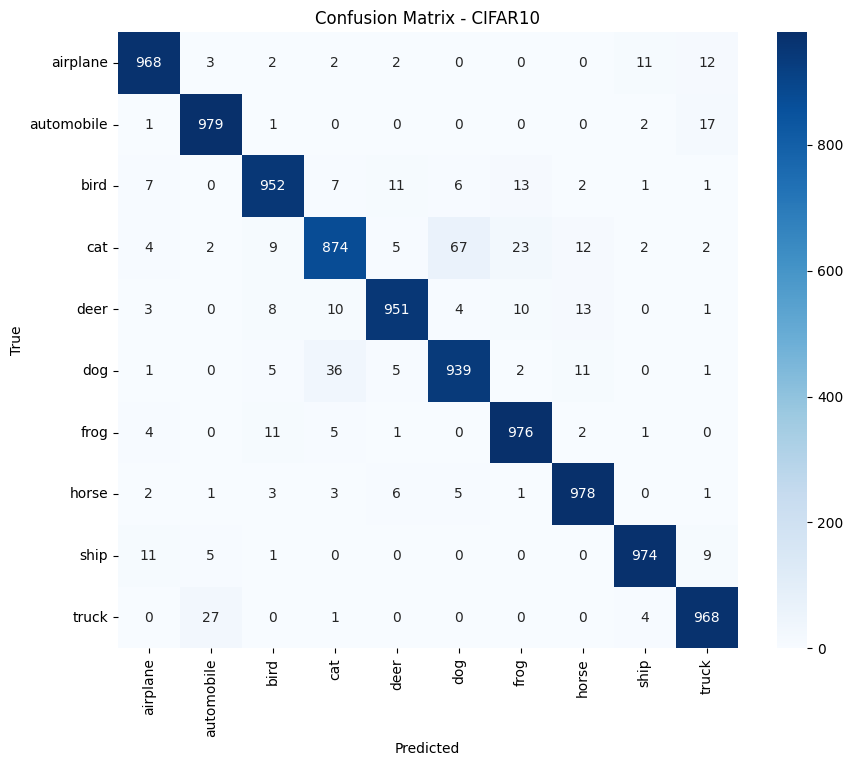

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR10")
plt.show()

# Visualization / Interpretability

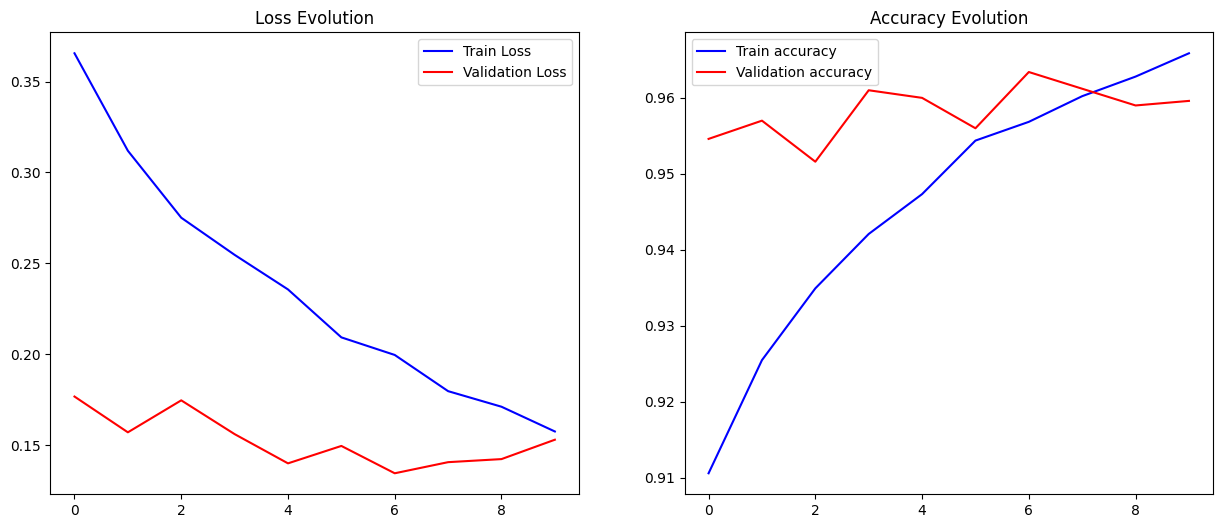

In [24]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(model.history.history['loss'], label = 'Train Loss', color = 'blue')
plt.plot(model.history.history['val_loss'], label = 'Validation Loss', color = 'red')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1,2,2)
plt.plot(model.history.history['acc'], label = 'Train accuracy', color = 'blue')
plt.plot(model.history.history['val_acc'], label = 'Validation accuracy', color = 'red')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

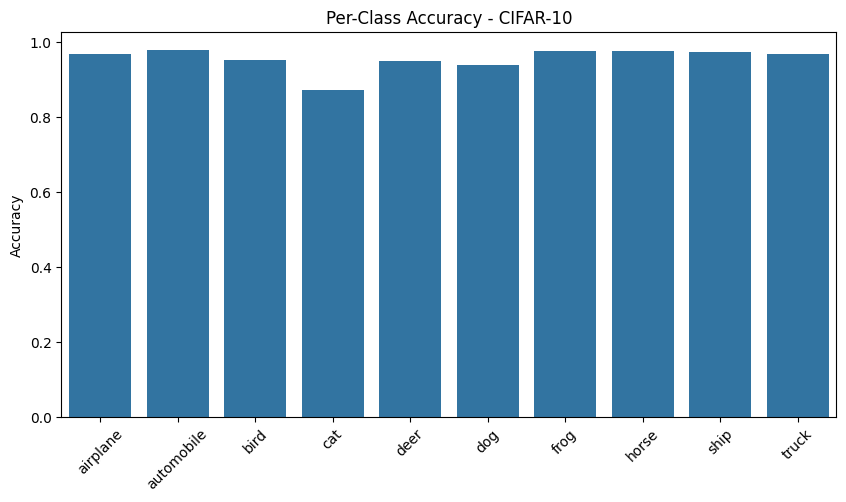

In [25]:
# Per-Class Accuracy Bar Plot

class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=class_accuracy)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy - CIFAR-10")
plt.show()

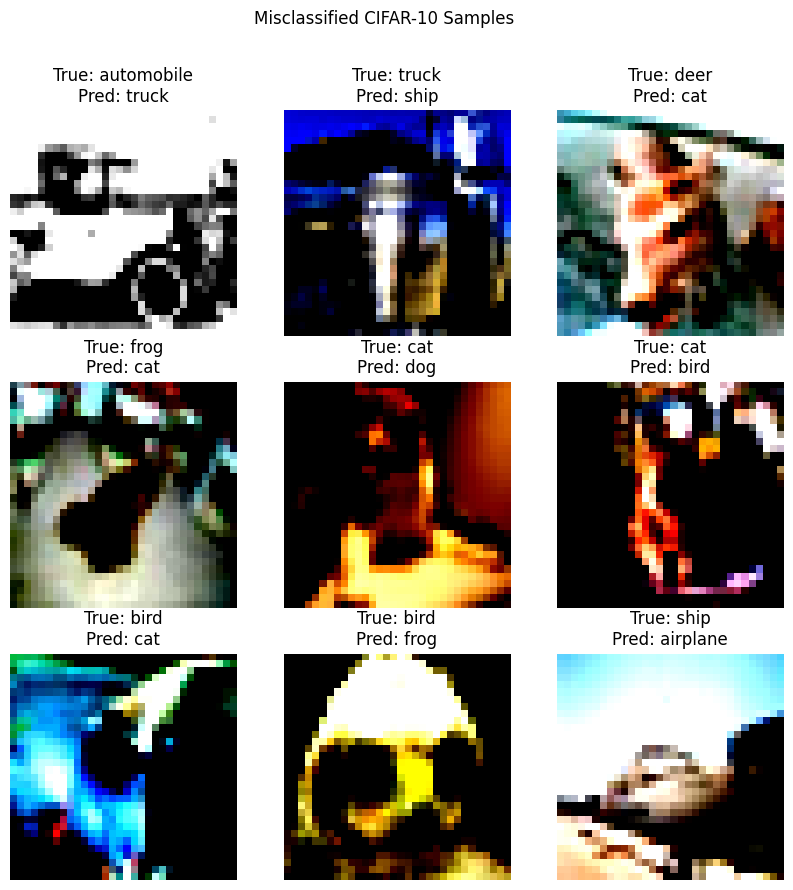

In [26]:
# Misclassified Images Visualization

mis_idx = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(10,10))

for i, idx in enumerate(mis_idx[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred_classes[idx]]}")
    plt.axis("off")

plt.suptitle("Misclassified CIFAR-10 Samples")
plt.show()

# Downloding model.h5 & model.keras file

In [27]:
from google.colab import files
model.save("cifar10_resnet50_model.h5")
files.download("cifar10_resnet50_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
model.save("cifar10_resnet50_model.keras")
files.download("cifar10_resnet50_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>